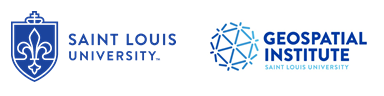

# Assignment 08: Forest Conservation with UNet (Part 1B Training)
## GIS 5092: Applied Machine Learning for GIS and Remote Sensing (Fall 2021)
Course Instructor: **Dr. Vasit Sagan** (vasit.sagan@slu.edu)
Teaching Assistant: **Sourav Bhadra** (sourav.bhadra@slu.edu)  
[Join Slack Workspace for this class](https://join.slack.com/t/gis5092-fall21/shared_invite/zt-u9vpmzat-SB5sYNtaPWk3vW_Qbj8QRQ)

## Learning Objectives:

* Develop UNet using Keras
* Train UNet architecture
* Retain performance evaluation scores

# Nothing to Submit for this Notebook

---

In [ ]:
# Make project folder as current working directory
import os
print(os.getcwd())

Z:\gis5092-fall21\assignments\A8_forest_conservation_unet


---

# Read data

In [ ]:
import numpy as np
# Read the np data
X_train = np.load(r'X_train.npy')
y_train = np.load(r'y_train.npy')
X_test = np.load(r'X_test.npy')
y_test = np.load(r'y_test.npy')

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70, 256, 256, 16)
(70, 256, 256, 11)
(30, 256, 256, 16)
(30, 256, 256, 11)


# Import modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, BatchNormalization, 
                                     Flatten, Activation, Dropout, Concatenate)
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow import keras 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

# Hyperparameters

In [ ]:
# Input hyperparameters
height= 256
width = 256
n_classes= 11
n_bands= 16

# Model hyperparameters
learning_rate = 0.001

# Build model

U-net looks like a U shaped architecture where the first half convolve the input images and the second hal deconvolve/upsample the the images for generating a classified map.

![u-net-architecture.png](attachment:u-net-architecture.png)

In [ ]:
def unet():

    img_input = Input(shape=(height, width, n_bands))

    ## Encoder layers
    # Block 1
    conv1e = Conv2D(64, (3,3), activation='relu', padding='same')(img_input)
    conv1e = Dropout(0.2)(conv1e)
    conv1e = Conv2D(64, (3,3), activation='relu', padding='same')(conv1e) 
    pool1e = MaxPooling2D((2,2), strides=2)(conv1e)

    # Block 2
    conv2e = Conv2D(128, (3,3), activation='relu', padding='same')(pool1e)
    conv2e = Dropout(0.2)(conv2e)
    conv2e = Conv2D(128, (3,3), activation='relu', padding='same')(conv2e) 
    pool2e = MaxPooling2D((2,2), strides=2)(conv2e) 

    # Block 3
    conv3e = Conv2D(256, (3,3), activation='relu', padding='same')(pool2e)
    conv3e = Dropout(0.2)(conv3e)
    conv3e = Conv2D(256, (3,3), activation='relu', padding='same')(conv3e) 
    pool3e = MaxPooling2D((2,2), strides=2)(conv3e) 

    # Block 4
    conv4e = Conv2D(512, (3,3), activation='relu', padding='same')(pool3e)
    conv4e = Dropout(0.2)(conv4e)
    conv4e = Conv2D(512, (3,3), activation='relu', padding='same')(conv4e) 
    pool4e = MaxPooling2D((2,2), strides=2)(conv4e) 

    # Bottleneck
    conv5 = Conv2D(1024, (3,3), activation='relu', padding='same')(pool4e)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(1024, (3,3), activation='relu', padding='same')(conv5)


    ## Decoder layers
    # Block 4
    up4 = Concatenate(axis=-1)([UpSampling2D((2, 2))(conv5), conv4e])
    conv4d = Conv2D(512, (3,3), activation='relu', padding='same')(up4)
    conv4d = Dropout(0.2)(conv4d)
    conv4d = Conv2D(512, (3,3), activation='relu', padding='same')(conv4d) 

    # Block 3
    up3 = Concatenate(axis=-1)([UpSampling2D((2, 2))(conv4d), conv3e])
    conv3d = Conv2D(256, (3,3), activation='relu', padding='same')(up3)
    conv3d = Dropout(0.2)(conv3d)
    conv3d = Conv2D(256, (3,3), activation='relu', padding='same')(conv3d)

    # Block 2
    up2 = Concatenate(axis=-1)([UpSampling2D((2, 2))(conv3d), conv2e])
    conv2d = Conv2D(128, (3,3), activation='relu', padding='same')(up2)
    conv2d = Dropout(0.2)(conv2d)
    conv2d = Conv2D(128, (3,3), activation='relu', padding='same')(conv2d) 

    # Block 1
    up1 = Concatenate(axis=-1)([UpSampling2D((2, 2))(conv2d), conv1e]) 
    conv1d = Conv2D(32, (3,3), activation='relu', padding='same')(up1)
    conv1d = Dropout(0.2)(conv1d)
    conv1d = Conv2D(32, (3,3), activation='relu', padding='same')(conv1d)

    out = Conv2D(n_classes, (1,1) , padding='same')(conv1d)
    out = Activation('softmax')(out)

    model = Model(img_input, out)

    return model

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 16 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9280        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
# Compile
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics= ['categorical_accuracy'])

In [ ]:
# Checkpoint
checkpoint = ModelCheckpoint(filepath='unet.hdf5',
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=14, epochs=50, validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/50
4/4 [==============================] - 16s 2s/step - loss: 3.4983 - categorical_accuracy: 0.3373 - val_loss: 2.3592 - val_categorical_accuracy: 0.3672

Epoch 00001: val_loss improved from inf to 2.35915, saving model to unet.hdf5
Epoch 2/50
4/4 [==============================] - 1s 285ms/step - loss: 2.3013 - categorical_accuracy: 0.2770 - val_loss: 2.4640 - val_categorical_accuracy: 0.2265

Epoch 00002: val_loss did not improve from 2.35915
Epoch 3/50
4/4 [==============================] - 1s 284ms/step - loss: 3.1093 - categorical_accuracy: 0.3339 - val_loss: 2.3131 - val_categorical_accuracy: 0.3649

Epoch 00003: val_loss improved from 2.35915 to 2.31310, saving model to unet.hdf5
Epoch 4/50
4/4 [==============================] - 1s 291ms/step - loss: 2.2865 - categorical_accuracy: 0.4091 - val_loss: 2.2920 - val_categorical_accuracy: 0.3649

Epoch 00004: val_loss improved from 2.31310 to 2.29202, saving model to unet.hdf5
Epoch 5/50
4/4 [==============================] -

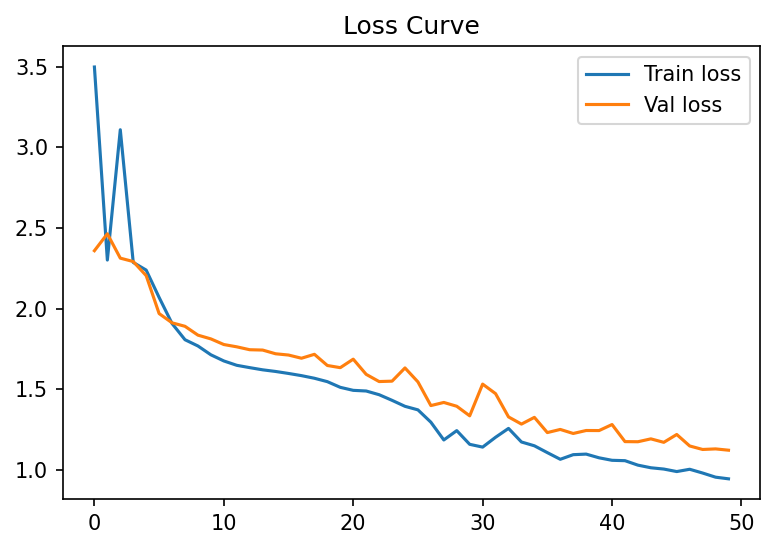

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=150)

ax.plot(history.history['loss'], label='Train loss')
ax.plot(history.history['val_loss'], label='Val loss')
ax.legend()
ax.set_title('Loss Curve')

plt.show()

# Performance evaluation

In [ ]:
# Predictions for training data
y_pred_train_1hot = model.predict(X_train)
y_pred_train_series = np.argmax(y_pred_train_1hot, axis=-1)

# Reverse one-hot encoding for y_train 
y_train_series = np.argmax(y_train, axis=-1)

In [ ]:
# Predictions for testing data
y_pred_test_1hot = model.predict(X_test)
y_pred_test_series = np.argmax(y_pred_test_1hot, axis=-1)

# Reverse one-hot encoding for y_test 
y_test_series = np.argmax(y_test, axis=-1)

Get information on which classes were preicted and how many pixels were for each of those classes.

In [ ]:
pd.DataFrame(np.unique(y_test_series, return_counts=True))

,0,1,2,3,4,5,6,7,8,9,10
0,0,1,2,3,4,5,6,7,8,9,10
1,387586,426076,9516,26419,65999,81253,828686,36689,24027,66339,13490


In [ ]:
pd.DataFrame(np.unique(y_pred_test_series, return_counts=True))

,0,1,2,3,4
0,0,1,4,5,6
1,224341,510086,18,132285,1099350


In [ ]:
print('Train accuracy: %f' % accuracy_score(y_train_series.reshape(-1), y_pred_train_series.reshape(-1)))

Train accuracy: 0.683478


In [ ]:
print('Test accuracy: %f' % accuracy_score(y_test_series.reshape(-1), y_pred_test_series.reshape(-1)))

Test accuracy: 0.697821
